# Visualizing Classical Music Influence with `networkx`

## 0. Introduction

## 1. Scraping the data

In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt

In [2]:
import codecs
import json
import urllib

from requests import get
from bs4 import BeautifulSoup
import networkx as nx

In [3]:
pages = [
    'https://en.wikipedia.org/wiki/List_of_music_students_by_teacher:_A_to_B',
    'https://en.wikipedia.org/wiki/List_of_music_students_by_teacher:_C_to_F',
    'https://en.wikipedia.org/wiki/List_of_music_students_by_teacher:_G_to_J',
    'https://en.wikipedia.org/wiki/List_of_music_students_by_teacher:_K_to_M',
    'https://en.wikipedia.org/wiki/List_of_music_students_by_teacher:_N_to_Q',
    'https://en.wikipedia.org/wiki/List_of_music_students_by_teacher:_R_to_S',
    'https://en.wikipedia.org/wiki/List_of_music_students_by_teacher:_T_to_Z'
]

In [4]:
adjlist = ''

for url in pages:
    response = get(url)
    soup = BeautifulSoup(response.text, 'html.parser')
    
    for heading in soup.find_all('h3'):
        if not heading.find('a'):
            continue
        url = heading.find('a')['href']
        if '/wiki/' not in url:
            continue
        teacher_name = url.split('/wiki/')[1].split('_(')[0].split('#')[0]

        student_entries = heading.find_next_sibling("div", class_="columns").find_all('li')
        student_names = []
        for student in student_entries:
            if not student.find('a'):
                continue

            url = student.find('a')['href']
            if '/wiki/' in url:
                student_names.append(url.split('/wiki/')[1].split('_(')[0].split('#')[0])

        adjlist += '{} {}\n'.format(teacher_name, ' '.join(student_names))

In [5]:
adjlist[:1000]

'Arkady_Abaza Nikolai_Roslavets\nChristian_Ferdinand_Abel Carl_Friedrich_Abel\nHermann_Abendroth Allard_de_Ridder Herbert_Eimert G%C3%BCnther_Herbig Wilhelm_Sch%C3%BCchter William_Steinberg\nDieter_Acker Susanne_Erding-Swiridoff\nAdolphe_Adam L%C3%A9o_Delibes Ferdinand_Poise Lo%C3%AFsa_Puget\nLouis_Adam Joseph_Daussoigne-M%C3%A9hul Ferdinand_H%C3%A9rold Friedrich_Kalkbrenner Henry_Lemoine\nJohn_Luther_Adams Corey_Dargel\nMurray_Adaskin Andrew_Dawes Boyd_McDonald Paul_Pedersen Rodney_Sharman Timothy_Williams\nGuido_Adler Karel_Navr%C3%A1til Anton_Webern Egon_Wellesz\nOskar_Adler Hans_Keller J%C3%B3zef_Koffler Dragan_Plamenac Arnold_Schoenberg\nSamuel_Adler Martin_Amlin Claude_Baker Roger_Briggs Jason_Robert_Brown David_Crumb Greg_Danner Eric_Ewazen Peng-Peng_Gong Jay_Greenberg Anthony_Iannaccone Kamran_Ince Michael_Isaacson Scott_Lindroth Marc_Mellits Carter_Pann Robert_Paterson Paul_Phillips Paul_Reller Michael_Alec_Rose Daria_Semegen Gordon_Stout Christopher_Theofanidis Michael_Sidney

In [6]:
adjlist = urllib.unquote(adjlist).decode('utf-8')

In [7]:
print adjlist[:1000]

Arkady_Abaza Nikolai_Roslavets
Christian_Ferdinand_Abel Carl_Friedrich_Abel
Hermann_Abendroth Allard_de_Ridder Herbert_Eimert Günther_Herbig Wilhelm_Schüchter William_Steinberg
Dieter_Acker Susanne_Erding-Swiridoff
Adolphe_Adam Léo_Delibes Ferdinand_Poise Loïsa_Puget
Louis_Adam Joseph_Daussoigne-Méhul Ferdinand_Hérold Friedrich_Kalkbrenner Henry_Lemoine
John_Luther_Adams Corey_Dargel
Murray_Adaskin Andrew_Dawes Boyd_McDonald Paul_Pedersen Rodney_Sharman Timothy_Williams
Guido_Adler Karel_Navrátil Anton_Webern Egon_Wellesz
Oskar_Adler Hans_Keller Józef_Koffler Dragan_Plamenac Arnold_Schoenberg
Samuel_Adler Martin_Amlin Claude_Baker Roger_Briggs Jason_Robert_Brown David_Crumb Greg_Danner Eric_Ewazen Peng-Peng_Gong Jay_Greenberg Anthony_Iannaccone Kamran_Ince Michael_Isaacson Scott_Lindroth Marc_Mellits Carter_Pann Robert_Paterson Paul_Phillips Paul_Reller Michael_Alec_Rose Daria_Semegen Gordon_Stout Christopher_Theofanidis Michael_Sidney_Timpson Fisher_Tull Dan_Welcher Michael_Glenn_Will

In [8]:
with codecs.open("adjlist.txt", "w", "utf-8") as temp:
    temp.write(adjlist)

In [9]:
G = nx.read_adjlist('adjlist.txt', create_using=nx.DiGraph())

In [10]:
def pretty_node(node):
    return u'{}. {}'.format(node[0], node.split('_I')[0].split('_')[-1])

In [11]:
def export_to_cytoscape_json(graph, filename, weight_fn=None):
    def exported_node(node, weight_fn=None):
        return {
            'data': {
                'id': unicode(pretty_node(node)),
                'fullName': unicode(node.replace('_', ' ')),
                'weight': weight_fn(node) if weight_fn else 1
            }
        }
    
    # Topologically sort the nodes if possible (i.e. the graph is acyclic)
    try:
        nodes = [exported_node(i, weight_fn) for i in nx.topological_sort(graph)]
    except:
        nodes = [exported_node(i, weight_fn) for i in graph.nodes()]
    links = [{'data': {'source': pretty_node(u[0]), 'target': pretty_node(u[1])}} for u in graph.edges()]
    with codecs.open(filename, "w", "utf-8") as file:
        json.dump(nodes + links, file, indent=2)

In [12]:
export_to_cytoscape_json(G, 'cytoscape.json')

## 2. Who are the most influential teachers?

In [13]:
c = nx.katz_centrality(G.reverse(), alpha=0.1)

In [14]:
for teacher in sorted(c, key=c.get)[::-1][:20]:
    print teacher, c[teacher]

Nadia_Boulanger 0.274464766203
Darius_Milhaud 0.133984907008
Karlheinz_Stockhausen 0.112095058281
Olivier_Messiaen 0.108104999101
Roger_Sessions 0.0924535118831
André_Gedalge 0.0821795297328
Vincent_d'Indy 0.0676563365134
Arnold_Schoenberg 0.067113904931
Paul_Hindemith 0.0660738864042
Charles-Marie_Widor 0.0585465871662
Gabriel_Fauré 0.0567998995
Franz_Liszt 0.0564699447567
Aaron_Copland 0.0560713201348
Antoine_François_Marmontel 0.0542184811049
Louis_Vierne 0.0539401495126
Louis_Andriessen 0.0533430371564
Charles_Villiers_Stanford 0.0533227668023
Milton_Babbitt 0.0531766068805
Ferruccio_Busoni 0.0523346432626
Salomon_Jadassohn 0.0500280441408


In [16]:
most_important_teachers = sorted(c, key=c.get)[::-1][:100]

In [17]:
important_teachers_graph = nx.subgraph(G, most_important_teachers)

## 3. Let's visualize it!

In [18]:
# https://stackoverflow.com/questions/29586520/can-one-get-hierarchical-graphs-from-networkx-with-python-3/29597209
def hierarchy_pos(G, root, levels=None, width=1., height=1.):
    '''If there is a cycle that is reachable from root, then this will see infinite recursion.
       G: the graph
       root: the root node
       levels: a dictionary
               key: level number (starting from 0)
               value: number of nodes in this level
       width: horizontal space allocated for drawing
       height: vertical space allocated for drawing'''
    TOTAL = "total"
    CURRENT = "current"
    def make_levels(levels, node=root, currentLevel=0, parent=None):
        """Compute the number of nodes for each level
        """
        if not currentLevel in levels:
            levels[currentLevel] = {TOTAL : 0, CURRENT : 0}
        levels[currentLevel][TOTAL] += 1
        try:
            neighbors = G.neighbors(node)
            for neighbor in neighbors:
                if not neighbor == parent:
                    levels =  make_levels(levels, neighbor, currentLevel + 1, node)
        except:
            pass
        return levels

    def make_pos(pos, node=root, currentLevel=0, parent=None, vert_loc=0):
        dx = 1.0/levels[currentLevel][TOTAL]
        left = dx/2
        pos[node] = ((left + dx*levels[currentLevel][CURRENT])*width, vert_loc)
        levels[currentLevel][CURRENT] += 1
        try:
            neighbors = G.neighbors(node)
            for neighbor in neighbors:
                if not neighbor == parent:
                    pos = make_pos(pos, neighbor, currentLevel + 1, node, vert_loc-vert_gap)
        except:
            pass
        return pos
    
    if levels is None:
        levels = make_levels({})
    else:
        levels = {l:{TOTAL: levels[l], CURRENT:0} for l in levels}
    vert_gap = height / (max([l for l in levels])+1)
    return make_pos({})

In [19]:
def draw_hierarchical_graph(graph, root=None):
    plt.figure(figsize=(10, 10))

    root = root or nx.topological_sort(graph).next()
    pos = hierarchy_pos(graph, root)
    reduced_graph = nx.subgraph(graph, pos.keys())
    
    relabeled_graph = nx.relabel_nodes(reduced_graph, pretty_node)
    relabeled_pos = {pretty_node(node): p for node, p in pos.items()}
    nx.draw(relabeled_graph, pos=relabeled_pos, with_labels=True, node_size=500, node_color='w', font_size=9, arrowsize=8)

<IPython.core.display.Javascript object>


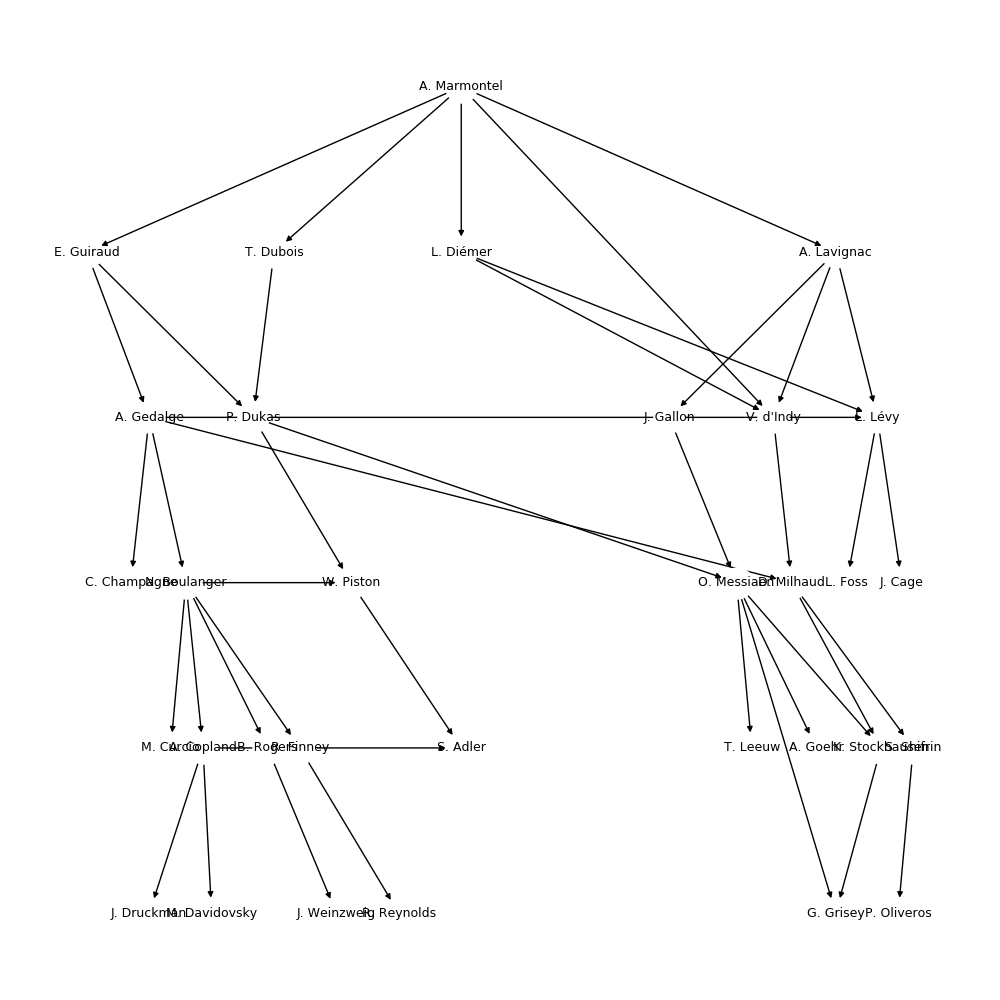

In [20]:
draw_hierarchical_graph(important_teachers_graph)

## 4. The missing links

In [21]:
most_important_teachers_students = set([n for t in most_important_teachers for n in G.successors(t)])

In [22]:
def has_important_students(teacher):
    students = [s for s in G.successors(teacher)]
    return any([student in most_important_teachers for student in students])

most_important_teachers_and_important_students = \
    set(most_important_teachers) | set([p for p in most_important_teachers_students if has_important_students(p)])           

In [23]:
print len(most_important_teachers)
print len(most_important_teachers_and_important_students)
print len(most_important_teachers_students)
print G.number_of_nodes()

100
132
1904
4926


In [24]:
most_important_teachers_and_important_students - set(most_important_teachers)

{u'Alban_Berg',
 u'Aleksander_Micha\u0142owski',
 u'Anna_Yesipova',
 u'Charles_Koechlin',
 u'Charles_Wood',
 u'Ernst_Krenek',
 u'Eusebius_Mandyczewski',
 u'Franz_Lachner',
 u'Friedrich_Kiel',
 u'Fritz_Reiner',
 u'Gian_Carlo_Menotti',
 u'Hans_von_Koessler',
 u'Henri_Dutilleux',
 u'Henri_Vieuxtemps',
 u'Henry_Cowell',
 u'Horatio_Parker',
 u'Isidor_Seiss',
 u'Istv\xe1n_Thom\xe1n',
 u'Jacques-Nicolas_Lemmens',
 u'Johann_Nepomuk_Hummel',
 u'Louis_Niedermeyer',
 u'Ludwig_Thuille',
 u'Ludwig_van_Beethoven',
 u'Marcel_Dupr\xe9',
 u'Marion_Bauer',
 u'Maurice_Ravel',
 u'Orpha-F._Deveaux',
 u'Paul_Pisk',
 u'Peter_Mennin',
 u'Roberto_Gerhard',
 u'Romain-Octave_Pelletier_I',
 u'Stephen_Heller'}

In [25]:
teacher_and_student_subgraph = nx.subgraph(G, most_important_teachers_and_important_students)

In [26]:
try:
    print [x for x in nx.topological_sort(teacher_and_student_subgraph)]
except Exception:
    import traceback
    traceback.print_exc()

Traceback (most recent call last):
  File "<ipython-input-26-280518520b52>", line 2, in <module>
    print [x for x in nx.topological_sort(teacher_and_student_subgraph)]
  File "/Users/alex/src/music-graph/env/lib/python2.7/site-packages/networkx/algorithms/dag.py", line 208, in topological_sort
    raise nx.NetworkXUnfeasible("Graph contains a cycle or graph changed "
NetworkXUnfeasible: Graph contains a cycle or graph changed during iteration


In [27]:
for cycle in nx.simple_cycles(teacher_and_student_subgraph):
    print cycle

[u'Claude_Champagne', u'Orpha-F._Deveaux']
[u'Simon_Sechter', u'Henri_Vieuxtemps']


In [28]:
most_important_teachers_and_important_students.remove(u'Orpha-F._Deveaux')
most_important_teachers_and_important_students.remove(u'Henri_Vieuxtemps')

In [29]:
teacher_and_student_subgraph = nx.subgraph(G, most_important_teachers_and_important_students)

<IPython.core.display.Javascript object>


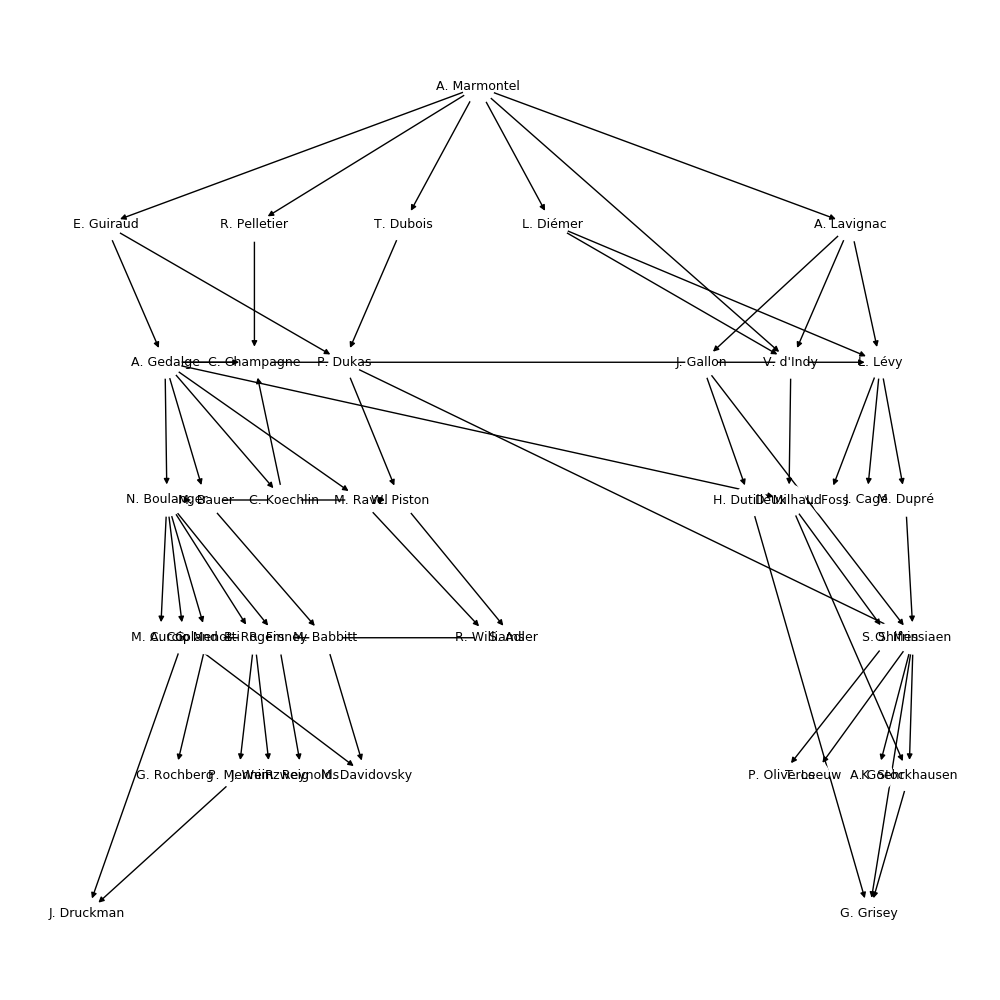

In [30]:
draw_hierarchical_graph(teacher_and_student_subgraph)

## 5. The Beethoven tree

<IPython.core.display.Javascript object>


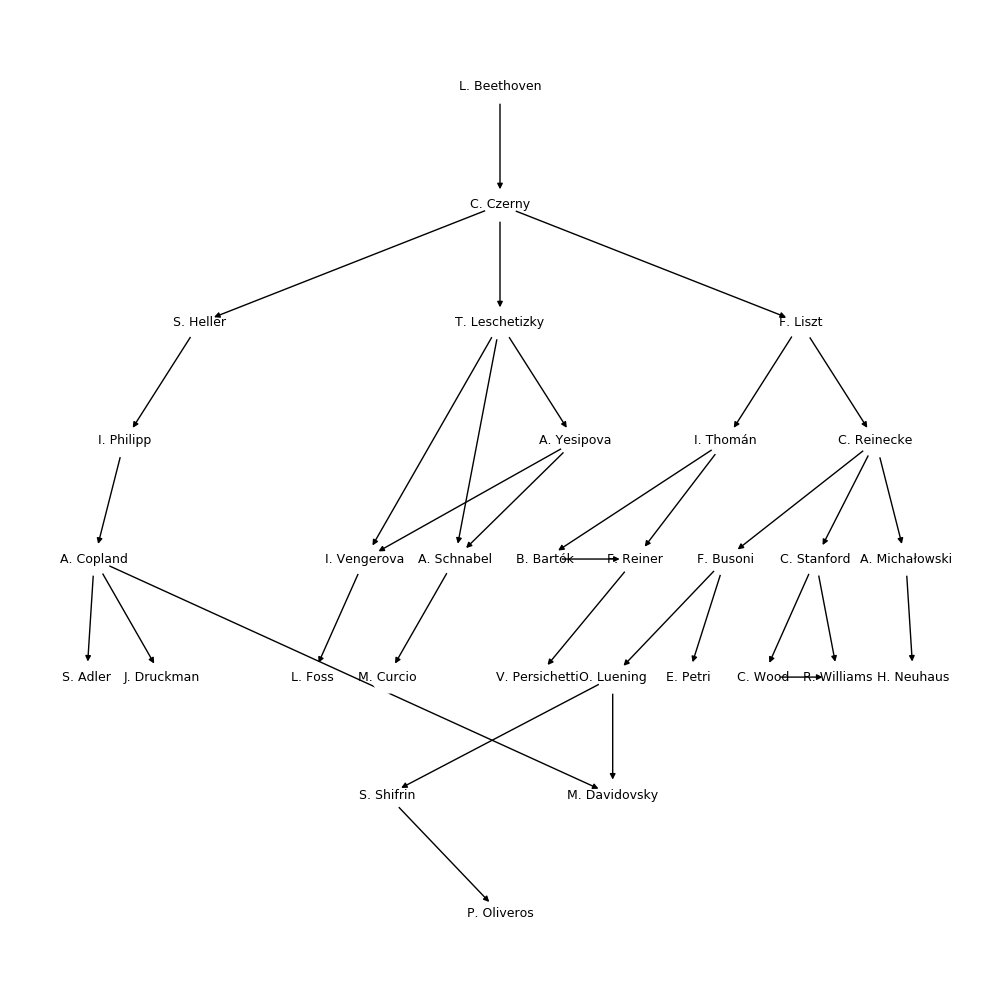

In [31]:
draw_hierarchical_graph(teacher_and_student_subgraph, 'Ludwig_van_Beethoven')

![](https://img.apmcdn.org/19bd838d5e9e2d7da767e13e83aa551074e4ed12/uncropped/f62292-20131108-carl-czerny-forefather-pianoforte-technique.jpg)

## 6. Before Beethoven

We can also try taking the graph one level deeper into the past but starting from one of Beethoven's teachers instead of Beethoven himself. Who were his teachers, anyway?

In [32]:
[x for x in teacher_and_student_subgraph.predecessors('Ludwig_van_Beethoven')]

[u'Antonio_Salieri', u'Johann_Georg_Albrechtsberger']

Let's arbitrarily pick Albrechtsberger to start with:

<IPython.core.display.Javascript object>


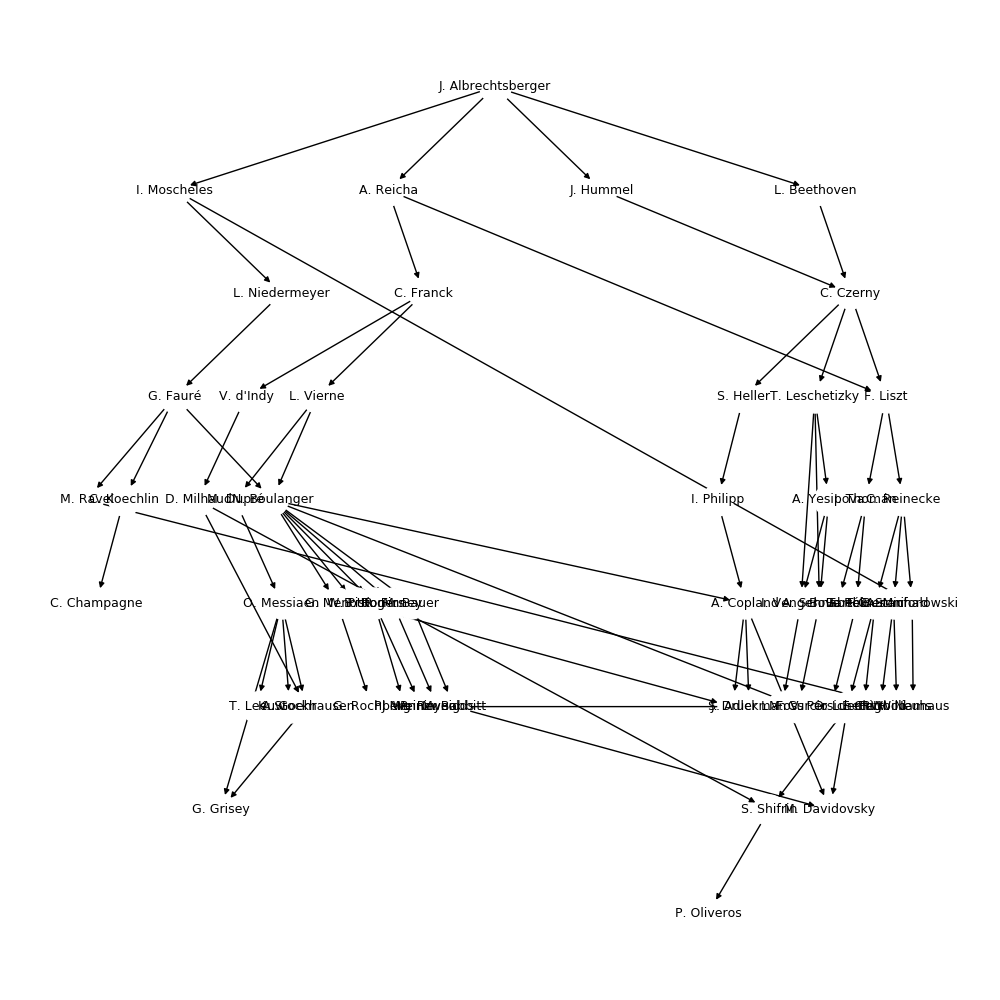

In [33]:
draw_hierarchical_graph(teacher_and_student_subgraph, u'Johann_Georg_Albrechtsberger')

Oof, that's a messy graph. What if instead of using `teacher_and_student_subgraph` we fall back to the more restrictive `important_teachers_graph`?

With Beethoven and Hummel gone, the graph beomces more manageable, and includes an interesting tree descending from César Franck. Even here it's hard to miss Nadia Boulanger's influence!

<IPython.core.display.Javascript object>


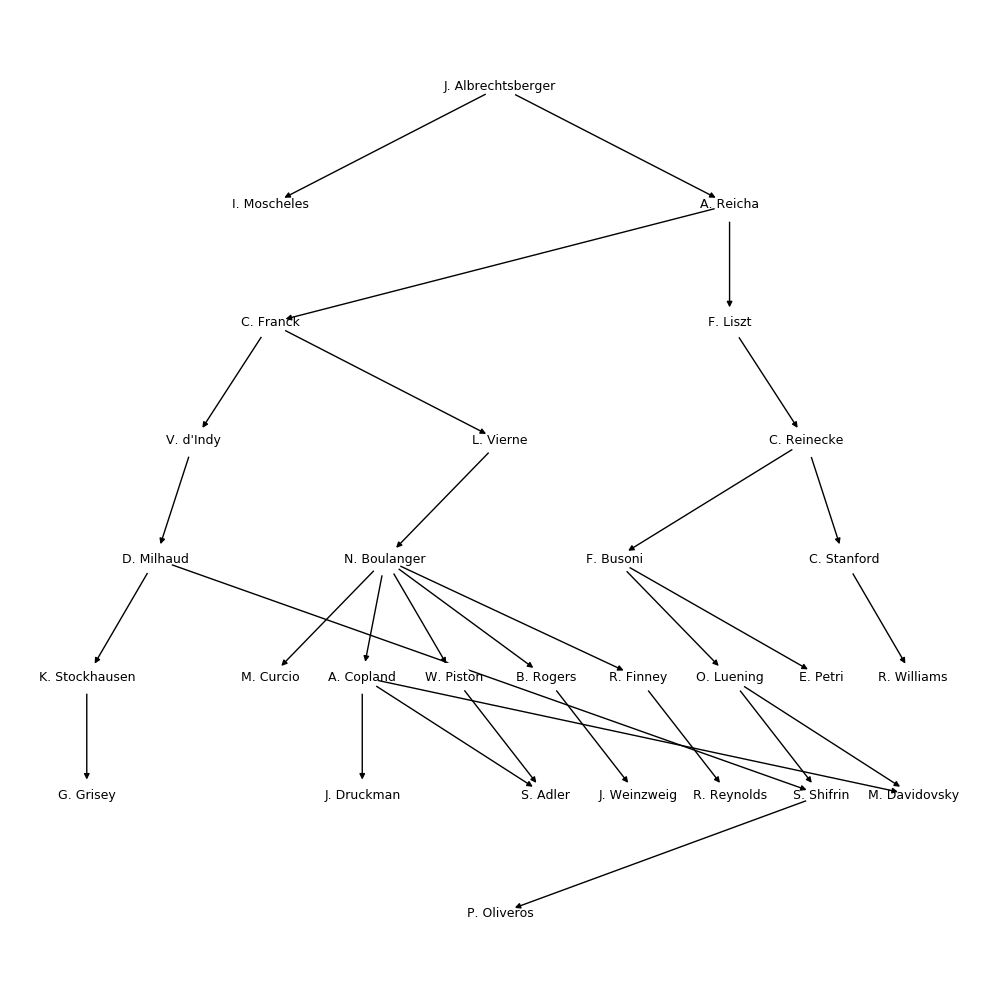

In [35]:
draw_hierarchical_graph(important_teachers_graph, u'Johann_Georg_Albrechtsberger')

Is there a path between J.S. Bach and Beethoven? There is, but it passes through some low-ranked teachers who didn't make it into our subgraph – Homilius, Hiller, and Neefe: 

In [47]:
for n in nx.shortest_path(G, 'Johann_Sebastian_Bach', 'Ludwig_van_Beethoven'):
    print u'{} [{:.4f}]'.format(n.replace('_', ' '), c[n])

Johann Sebastian Bach [0.0405]
Gottfried August Homilius [0.0169]
Johann Adam Hiller [0.0154]
Christian Gottlob Neefe [0.0124]
Ludwig van Beethoven [0.0173]


## 7. What's the longest path?

We can use networkx's `dag_longest_path` algorithm to find the longest path within our graph. The only catch is that the notion of "longest path" is meaningless in a graph that contains cycles:

In [37]:
try:
    print nx.dag_longest_path(G)
except Exception:
    import traceback
    traceback.print_exc()

Traceback (most recent call last):
  File "<ipython-input-37-00dbbde4bbf0>", line 2, in <module>
    print nx.dag_longest_path(G)
  File "<decorator-gen-376>", line 2, in dag_longest_path
  File "/Users/alex/src/music-graph/env/lib/python2.7/site-packages/networkx/utils/decorators.py", line 82, in _not_implemented_for
    return not_implement_for_func(*args, **kwargs)
  File "/Users/alex/src/music-graph/env/lib/python2.7/site-packages/networkx/algorithms/dag.py", line 653, in dag_longest_path
    for v in nx.topological_sort(G):
  File "/Users/alex/src/music-graph/env/lib/python2.7/site-packages/networkx/algorithms/dag.py", line 208, in topological_sort
    raise nx.NetworkXUnfeasible("Graph contains a cycle or graph changed "
NetworkXUnfeasible: Graph contains a cycle or graph changed during iteration


How many cycles are there within the graph, anyway?

In [38]:
for cycle in nx.simple_cycles(G):
    print cycle

[u'Simon_Sechter', u'Henri_Vieuxtemps']
[u'Wladimir_Vogel', u'Erik_Bergman', u'Heinz_Tiessen']
[u'Wladimir_Vogel', u'Erik_Bergman']
[u'Claude_Champagne', u'Orpha-F._Deveaux']
[u'\u0218tefan_Niculescu', u'Mihail_Jora']


Removing individual edges seems to be a bit of a pain in networkx, so let's just take the easy way out and arbitrarily remove one node from each of the cycles:

In [39]:
G_without_cycles = nx.subgraph(G, [n for n in G.nodes if n not in [u'Henri_Vieuxtemps', u'Erik_Bergman', u'Orpha-F._Deveaux', u'Mihail_Jora']])

And let's double-check that we've actually gotten rid of all the cyles:

In [40]:
for cycle in nx.simple_cycles(G_without_cycles):
    print cycle

Great, now we can finally find the longest path:

In [41]:
for n in nx.dag_longest_path(G_without_cycles):
    print u'{} [{:.4f}]'.format(n.replace('_', ' '), c[n])

Orlande de Lassus [0.0147]
Andrea Gabrieli [0.0143]
Giovanni Gabrieli [0.0154]
Heinrich Schütz [0.0371]
Johann Schelle [0.0153]
Johann David Heinichen [0.0121]
Johann Georg Pisendel [0.0139]
Franz Benda [0.0193]
Johann Wilhelm Hertel [0.0120]
Carl Friedrich Christian Fasch [0.0137]
Carl Friedrich Zelter [0.0189]
Carl Friedrich Rungenhagen [0.0197]
Franz Wüllner [0.0225]
Hans von Koessler [0.0244]
Ernő Dohnányi [0.0285]
Béla Bartók [0.0330]
Fritz Reiner [0.0169]
Vincent Persichetti [0.0337]
Paavo Heininen [0.0172]
Jouni Kaipainen [0.0117]
Tomi Räisänen [0.0107]


Wow, an unbroken link from [Orlande de Lassus](https://en.wikipedia.org/wiki/Orlande_de_Lassus) (1532–1594) all the way to [Tomi Räisänen](https://en.wikipedia.org/wiki/Tomi_R%C3%A4is%C3%A4nen) (1976–)!

## 8. Could we see the whole network?

Are all of the 132 people in `teacher_and_student_subgraph` connected? We can figure this out by determining the [_weakly connected components_](http://mathworld.wolfram.com/WeaklyConnectedComponent.html) of the graph (_weakly_ meaning that the direction of each link doesn't matter): 

In [42]:
for comp in nx.weakly_connected_components(teacher_and_student_subgraph):
    print len(comp), comp

111 set([u'Ernst_Krenek', u'Ton_de_Leeuw', u'George_Rochberg', u'Engelbert_Humperdinck', u'Louis_Vierne', u'Paul_Pisk', u'B\xe9la_Bart\xf3k', u'Heinrich_Neuhaus', u'Ralph_Vaughan_Williams', u'Henri_Dutilleux', u'Charles_Wood', u'Karlheinz_Stockhausen', u'Simon_Sechter', u'Th\xe9odore_Dubois', u'Roger_Sessions', u'Roger_Reynolds', u'Charles_Koechlin', u'Franz_Liszt', u'Otto_Luening', u'Alban_Berg', u'Mario_Davidovsky', u'Howard_Hanson', u'Maria_Curcio', u'Gabriel_Faur\xe9', u'Edward_Burlingame_Hill', u'Friedrich_Kiel', u'John_Cage', u'Isabelle_Vengerova', u'Paul_Dukas', u'Maurice_Ravel', u'Ludwig_van_Beethoven', u'Horatio_Parker', u'Aaron_Copland', u'Gian_Carlo_Menotti', u'Lazare_L\xe9vy', u'Peter_Mennin', u'Seymour_Shifrin', u'G\xe9rard_Grisey', u'Alexander_Goehr', u'Nadia_Boulanger', u'Robert_Erickson', u'No\xebl_Gallon', u'Ludwig_Thuille', u'Jacques-Nicolas_Lemmens', u'Paul_Hindemith', u'Moritz_Hauptmann', u'Isidor_Philipp', u'Samuel_Adler', u'Carl_Czerny', u'Hans_von_Koessler', u'Ra

Looks like there's one massive connected component of 111 people (~85% of the whole graph), a few small 2-3 person chains, and about a dozen people on their own.

Let's try visualizing the graph made up of just the 111 people who are all connected:

In [43]:
connected_comp = nx.weakly_connected_components(teacher_and_student_subgraph).next()
connected_teacher_and_student_subgraph = nx.subgraph(teacher_and_student_subgraph, connected_comp)

<IPython.core.display.Javascript object>


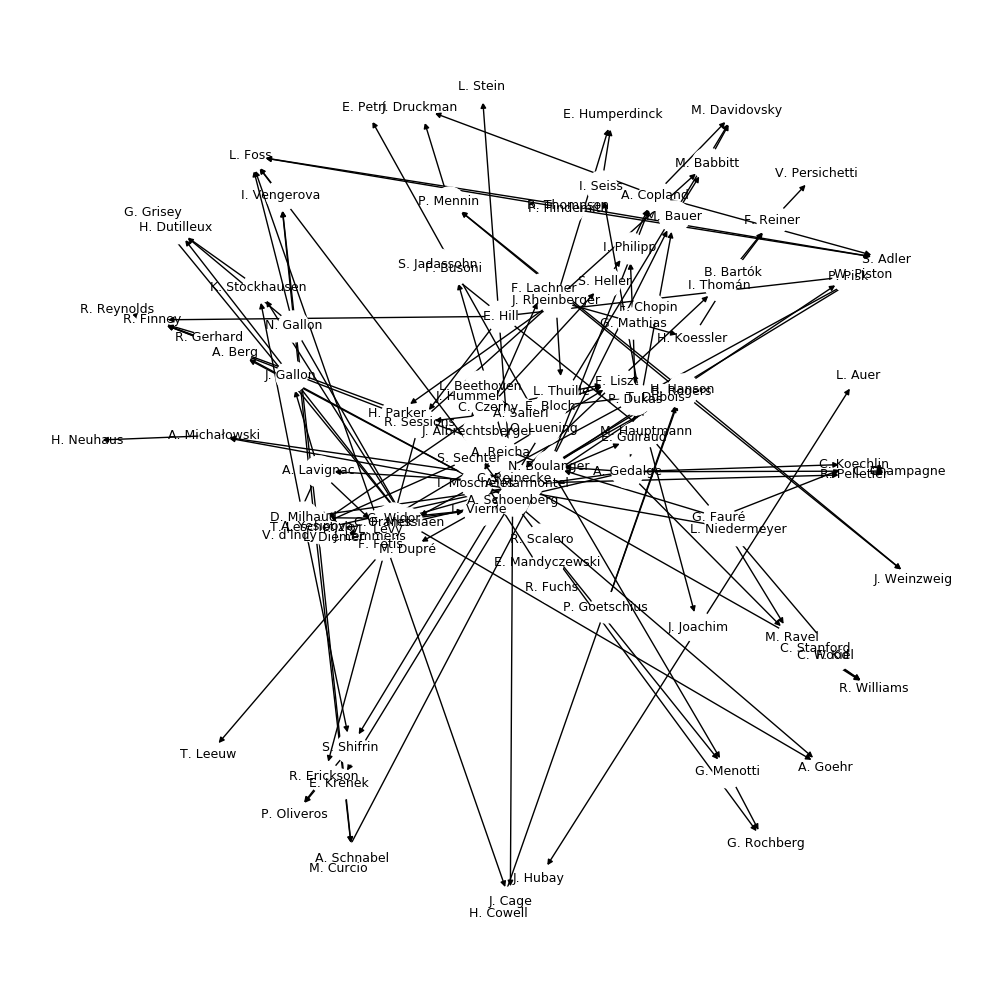

In [44]:
plt.figure(figsize=(10, 10))
connected_teacher_and_student_subgraph_pretty = nx.relabel_nodes(connected_teacher_and_student_subgraph, pretty_node)
nx.draw(connected_teacher_and_student_subgraph_pretty, with_labels=True, node_size=500, node_color='w', font_size=9, arrowsize=8)

Well, everyone is certainly connected, but there doesn't seem to be a good way visualize the graph using `networkx`. Let's export it to JSON instead so we can play around with it using [Cytoscape.js](http://js.cytoscape.org/).

In [46]:
def remap(x, in_min, in_max, out_min, out_max):
    return (x - in_min) * (out_max - out_min) / (in_max - in_min) + out_min

export_to_cytoscape_json(
    connected_teacher_and_student_subgraph,
    'cytoscape_connected_111.json', 
    weight_fn=lambda node: remap(c[node], min(c.values()), max(c.values()), 10, 200)
)

TODO put link to cytoscape visualization

## 9. In conclusion